In [1]:
#imports
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import ticker
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split 

2023-01-25 15:55:45.520524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 15:55:45.618723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/insa/lib:$LD_LIBRARY_PATH
2023-01-25 15:55:45.618739: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-25 15:55:47.764455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot o

## Data Recovery

In [2]:
data = pd.read_csv('data_pre.csv', index_col = 0)

In [3]:
data

Electricity demand  production_nette  production stock   index  \
0                 822.34           -238.12            244.84       0   
1                1011.52           -230.66            253.92      24   
2                1429.34             40.22            114.61      48   
3                1476.76            -25.91            162.37      72   
4                1464.01           -233.79            284.44      96   
...                  ...               ...               ...     ...   
6564             1395.76            -70.92            124.39  157536   
6565             1387.42             13.67             90.03  157560   
6566             1421.66           -169.79            169.77  157584   
6567             1401.63           -178.55            254.32  157608   
6568             1360.12            -55.72            148.99  157632   

      Stored phs  Stored battery  Stored methanation  days  cost_phs  \
0     100.000000      100.000000           80.483619     1  0.000608   
1     100.000000        0.000000           77.484681     2  0.000608   
2      91.461111        0.000000           73.569996     3  0.000608   
3      88.772222       35.554357           73.343739     4  0.000608   
4      81.144444      100.000000           71.943798     5  0.000608   
...          ...             ...                 ...   ...       ...   
6564   71.872222       71.216617           86.169233   360  0.000608   
6565   56.366667       78.041543           85.131638   361  0.000608   
6566  100.000000      100.000000           83.575204   362  0.000608   
6567   48.972222       86.080388           82.201024   363  0.000608   
6568   31.444444       42.230914           79.885016   364  0.000608   

      cost_bat  cost_met       cost  Stored24phs  Stored24battery  \
0     0.003235  0.003928  77.705064   100.000000         0.000000   
1     0.003087  0.004208  79.031328    91.461111         0.000000   
2     0.003182  0.003103  68.930476    88.772222        35.554357   
3     0.003113  0.003438  71.594721    81.144444       100.000000   
4     0.003112  0.004489  82.088458   100.000000       100.000000   
...        ...       ...        ...          ...              ...   
6564  0.003087  0.003327  70.220758    56.366667        78.041543   
6565  0.003087  0.003486  71.809862   100.000000       100.000000   
6566  0.003107  0.003430  71.457317    48.972222        86.080388   
6567  0.003172  0.003719  74.990028    31.444444        42.230914   
6568  0.003204  0.003010  68.212710     1.794444         0.000000   

      Stored24methanation  stock_day_phs  stock_day_battery  \
0               77.484681       0.000000        -100.000000   
1               73.569996      -8.538889           0.000000   
2               73.343739      -2.688889          35.554357   
3               71.943798      -7.627778          64.445643   
4               67.112806      18.855556           0.000000   
...                   ...            ...                ...   
6564            85.131638     -15.505556           6.824926   
6565            83.575204      43.633333          21.958457   
6566            82.201024     -51.027778         -13.919612   
6567            79.885016     -17.527778         -43.849474   
6568            79.932139     -29.650000         -42.230914   

      stock_day_methanation  
0                 -2.998938  
1                 -3.914685  
2                 -0.226256  
3                 -1.399942  
4                 -4.830992  
...                     ...  
6564              -1.037596  
6565              -1.556433  
6566              -1.374180  
6567              -2.316009  
6568               0.047123  

[6552 rows x 18 columns]

In [4]:
# Volume max for phs, battery, methanation
volume= pd.Series([180 ,74.14, 12499.09])

# charging efficiency for phs, batetry, methanation
eta_in = pd.Series([0.95, 0.9, 0.59])
# discharging efficiency for phs, batetry, methanation
eta_out = pd.Series([0.9, 0.95, 0.45])

# Charging capacity phs, battery, methanation (for 1 hour)
S = pd.Series([9.3, 20.08, 7.66])
# discharging capacity phs, battery, methanation (for 1 hour)
Q = pd.Series([9.3, 20.08, 32.93])

# charging/discharging capacity in % for each tech and by day
S_p = [9.3*100*24/volume[0], 20.8*100*24/volume[1], 7.66*100*24/volume[2]]
Q_p = [9.3*100*24/volume[0], 20.08*100*24/volume[1], 32.93*100*24/volume[2]]
print('S % : ', S_p)
print('Q % : ', Q_p)

S % :  [124.00000000000001, 673.3207445373617, 1.4708270762111482]
Q % :  [124.00000000000001, 650.0134879956837, 6.3230203158789955]


## Constraint functions 
- We define 3 main constraints explained more precisely in repport and test it on simulted dataset.

##### 1. Constraint on storage technology level : cannot exceed installed capacity

In [5]:
# Stock level have to be <= 100 % and > 0
def C_level (Stored):
    #############################
    ## Stored is the level of stock for 1 technology in % (depending on Volume_tec)    
    #############################
    print('data where stock level < 0 :', Stored.loc[Stored < 0])
    print('data where stock level > 100 :', Stored.loc[Stored > 100])
    return Stored.loc[Stored < 0], Stored.loc[Stored > 100]

In [6]:
print('for phs : ')
C_level(data['Stored24phs'])
print('for battery : ')
C_level(data['Stored24battery'])
print('for metahanation : ')
C_level(data['Stored24methanation'])

# This constraint is perfectly respected

for phs : 
data where stock level < 0 : Series([], Name: Stored24phs, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24phs, dtype: float64)
for battery : 
data where stock level < 0 : Series([], Name: Stored24battery, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24battery, dtype: float64)
for metahanation : 
data where stock level < 0 : Series([], Name: Stored24methanation, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24methanation, dtype: float64)


(Series([], Name: Stored24methanation, dtype: float64),
 Series([], Name: Stored24methanation, dtype: float64))

##### 2. Contraint on quantity stored or deststock limited by residual production

In [7]:
def C_residualprod(RP,eta_in, eta_out, delta_stock, volume):
    ################################################
    # RP is the residual production : production_nette
    # eta_in Charging efficiency of phs (0), battery (1), methanation (2)
    # eta_out Disharging efficiency of phs (0), battery (1), methanation (2)
    # delta_stock = variation des stocks dans la journée
    # volume = volume max of each tec (useful to unpercent)
    
    # return index of problem
    ################################################   
    
    deltaphs = delta_stock[0]*volume[0]/100
    deltabat = delta_stock[1]*volume[1]/100
    deltamet = delta_stock[2]*volume[2]/100
    #if delta_stock > 0
    deltaphs[deltaphs>0] = deltaphs[deltaphs>0]/eta_in[0]
    deltabat[deltabat>0] = deltabat[deltabat>0]/eta_in[1]
    deltamet[deltamet>0] = deltamet[deltamet>0]/eta_in[2]
    # if delta_stock < 0
    deltaphs[deltaphs<0] = deltaphs[deltaphs<0]*eta_out[0]
    deltabat[deltabat<0] = deltabat[deltabat<0]*eta_out[1]
    deltamet[deltamet<0] = deltamet[deltamet<0]*eta_out[2]

    SUM = deltaphs + deltabat + deltamet
    
    # in all cases : each day, RP have to be lower than sum
    
    print('here there is a problem : ', RP[RP<SUM ], SUM[RP[RP<SUM].index])
    
    return  RP[RP<SUM], SUM[RP[RP<SUM].index], deltaphs, deltabat, deltamet

In [8]:
RP,SUM, simu_phs, simu_bat, simu_met = C_residualprod(data.production_nette,eta_in, eta_out, [data.stock_day_phs, data.stock_day_battery, data.stock_day_methanation], volume)

here there is a problem :  6      -411.95
7      -360.56
8      -327.13
11     -489.08
351    -546.39
         ...  
6213   -327.13
6216   -489.08
6556   -546.39
6562    448.87
6566   -169.79
Name: production_nette, Length: 138, dtype: float64 6      -411.897237
7      -360.558263
8      -327.091500
11     -489.055895
351    -546.372000
           ...    
6213   -327.091500
6216   -489.055895
6556   -546.372000
6562    448.898920
6566   -169.761000
Length: 138, dtype: float64


In [9]:
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())
# the difference between constraint rejected with most différence is quite hight
# We can consider this value as an acceptable difference

Maximum difference obseved :  0.08800000000019281


##### 3. Constraint on charging and discharging capacity : 
- we cannot charge or dischage more than a fix quantity each day.
- In fact this constraint is only for methanation.

In [10]:
def C_charging_discharging(S_p, Q_p, eta_in, eta_out, delta_stock):
    ###############################################################
    # S_p Charging capacity methanation
    # Q_p Discharging capacity of methanation (2)
    # eta_in Charging efficiency  methanation (2)
    # eta_out Discharging efficiency of  methanation (2)
    # delta_stock : contain daily delta stock for methanation
    
    # return index where there is a problem
    ###############################################################
    # case delta_stock[2] > 0
    delta_met_p = delta_stock[delta_stock>=0]
    print ('too much stockage for methanation : ', delta_met_p[delta_met_p>S_p*eta_in])
    
    
    delta_met_n = delta_stock[delta_stock < 0]
    print ('too much destockage for methanation : ', delta_met_n[delta_met_n < - Q_p/eta_out])
    
    # case delta_stock[2] < 0
    return  delta_met_p[delta_met_p>S_p*eta_in], delta_met_n[delta_met_n < -Q_p/eta_out]

C, D = C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], data.stock_day_methanation)

# error are q_ème surement probably round error 

too much stockage for methanation :  29      0.867823
48      0.867823
60      0.867823
107     0.867823
122     0.867823
          ...   
6550    0.867823
6552    0.867823
6553    0.867823
6561    0.867823
6562    0.867823
Name: stock_day_methanation, Length: 784, dtype: float64
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)


In [11]:
print('Theorical maximum methanation : ', S_p[2]*eta_in[2], 'Theorical minimum : ', -Q_p[2]/eta_out[2])
print ('Maximum observed (if upper) : ', C.max(), 'Minimum observed (if lower) : ', D.min())


# We conclude what it is probably round error not important

Theorical maximum methanation :  0.8677879749645774 Theorical minimum :  -14.051156257508879
Maximum observed (if upper) :  0.8678231775273417 Minimum observed (if lower) :  nan


## Données d'entrées (X) / de sorties (Y) du réseau

 - production_nette  $\sum_{str} production - demand$
 - Stored tec = stock level at the beggining of the day

In [12]:
X = data[['production_nette','Stored phs', 'Stored battery', 'Stored methanation', 'days' ]]
#X

- stock_day_tec = quantity stocked suring day in % 

In [13]:
Y = data[['stock_day_phs', 'stock_day_battery', 'stock_day_methanation', 'cost']]
Y['stock_day_methanation'] = Y['stock_day_methanation']*7

/tmp/ipykernel_15998/3935254216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['stock_day_methanation'] = Y['stock_day_methanation']*7


In [14]:
#pas mis à jour
# pour modèle 3
Y_funk = data[[ 'Stored24phs', 'Stored24battery', 'Stored24methanation', 'production_nette', 'Stored phs', 'Stored battery', 'Stored methanation', 'cost']]
Y_funk

Stored24phs  Stored24battery  Stored24methanation  production_nette  \
0      100.000000         0.000000            77.484681           -238.12   
1       91.461111         0.000000            73.569996           -230.66   
2       88.772222        35.554357            73.343739             40.22   
3       81.144444       100.000000            71.943798            -25.91   
4      100.000000       100.000000            67.112806           -233.79   
...           ...              ...                  ...               ...   
6564    56.366667        78.041543            85.131638            -70.92   
6565   100.000000       100.000000            83.575204             13.67   
6566    48.972222        86.080388            82.201024           -169.79   
6567    31.444444        42.230914            79.885016           -178.55   
6568     1.794444         0.000000            79.932139            -55.72   

      Stored phs  Stored battery  Stored methanation       cost  
0     100.000000      100.000000           80.483619  77.705064  
1     100.000000        0.000000           77.484681  79.031328  
2      91.461111        0.000000           73.569996  68.930476  
3      88.772222       35.554357           73.343739  71.594721  
4      81.144444      100.000000           71.943798  82.088458  
...          ...             ...                 ...        ...  
6564   71.872222       71.216617           86.169233  70.220758  
6565   56.366667       78.041543           85.131638  71.809862  
6566  100.000000      100.000000           83.575204  71.457317  
6567   48.972222       86.080388           82.201024  74.990028  
6568   31.444444       42.230914           79.885016  68.212710  

[6552 rows x 8 columns]

### Entrance data normalisation

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = True
if scaler :
    scaler = StandardScaler()
    scaler.fit(X)
    XSc= scaler.transform(X)
    XSc = pd.DataFrame(XSc, index =X.index, columns = X.columns)
else : XSc = X.copy()

## Jeu de test et jeu d'entraînement

In [16]:
X_train,X_test,Y_train,Y_test = train_test_split(XSc,Y,test_size=0.25,random_state=13)

In [17]:
# version array pour utiliser la LOSS personnalisée
#Cette Loss ne prend pour l'instant en compte que dES numpy array modifiés
X_funk_train,X_funk_test,Y_funk_train,Y_funk_test = train_test_split(np.array(XSc),np.array(Y_funk),test_size=0.25,random_state=13)
X_funk_train = np.array(X_funk_train)
X_funk_test = np.array(X_funk_test)
Y_funk_train = np.array(Y_funk_train)
Y_funk_test = np.array(Y_funk_test)
x_funk_train, x_funk_val, y_funk_train, y_funk_val = train_test_split(np.array(X_funk_train), np.array(Y_funk_train), test_size=0.15, random_state=42)

In [18]:
#pour partie stockage
# on ne peut pas mélanger 2 années sinon on a un problème avec predict continu
a = 0
b = 364


# surement mieux de mélanger les trains
X_train_strat = pd.concat([XSc[0:a], XSc[b:]] ) #utilisation des données renormalisées
X_test_strat = XSc[a:b]
Y_train_strat = pd.concat([Y[0:a], Y[b:]])
Y_test_strat = Y[a:b]
X_test_strat

production_nette  Stored phs  Stored battery  Stored methanation  \
0           -1.476761    2.292299        2.714763            1.102883   
1           -1.454558    2.292299       -0.587959            1.011628   
2           -0.648339    2.007756       -0.587959            0.892507   
3           -0.845162    1.918154        0.586302            0.885622   
4           -1.463874    1.663972        2.714763            0.843022   
..                ...         ...             ...                 ...   
359         -0.979125    1.354993        1.764128            1.275893   
360         -0.727360    0.838299        1.989536            1.244319   
361         -1.273391    2.292299        2.714763            1.196958   
362         -1.299463    0.591893        2.255037            1.155143   
363         -0.933885    0.007813        0.806811            1.084668   

         days  
0   -1.727299  
1   -1.717782  
2   -1.708265  
3   -1.698749  
4   -1.689232  
..        ...  
359  1.689232  
360  1.698749  
361  1.708265  
362  1.717782  
363  1.727299  

[364 rows x 5 columns]

In [19]:
X_funk_train_strat = np.array(X_train_strat)
X_funk_test_strat = np.array(X_test_strat)
Y_funk_train_strat = np.array(pd.concat([Y_funk[0:a],Y_funk[b:]]))
Y_funk_test_strat = np.array(Y_funk[a:b])
x_funk_train_strat, x_funk_val_strat, y_funk_train_strat, y_funk_val_strat = train_test_split(np.array(X_funk_train), np.array(Y_funk_train), test_size=0.15, random_state=42)

## Modèles

In [20]:
#some useful methods

def compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly):
    model.compile(loss = loss,optimizer=optimiseur,metrics = metrics, loss_weights= loss_weights, run_eagerly = run_eagerly)
def train_model(model,X_train, Y_train, epoch, val):
    model.fit (X_train, Y_train, epochs = epoch, validation_split = val)
def train_model_funk(model, X_trainf, Y_trainf, epoch, val_data):
    model.fit (X_trainf, Y_trainf, epochs = epoch, validation_data = val_data)

In [21]:
def plot_pred ( Y_testr, predr ):
    fig0 = go.Figure()
    fig0.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_phs'], mode='lines', name = 'phs real'))
    fig0.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_phs'], mode='lines', name = 'phs predicted'))
    fig0.show()
    fig1 = go.Figure()
    fig1.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_battery'], mode='lines', name = 'battery real'))
    fig1.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_battery'], mode='lines', name = 'battery predicted'))
    fig1.show()
    fig2 = go.Figure()
    fig2.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_methanation'], mode='lines', name = 'methanation real'))
    fig2.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_methanation'], mode='lines', name = 'methanation predicted'))
    fig2.show()
    fig3 = go.Figure()
    fig3.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['cost'], mode='lines', name = 'cost real * 10000'))
    fig3.add_traces(go.Scatter(x = predr.index, y = predr['cost'], mode='lines', name = 'cost predicted *10000'))
    fig3.show()
    print('total cost real :', np.sum(Y_testr['cost'])/10000)
    print('total cost predicted :', np.sum(predr['cost'])/10000)

### 1/ Premier modèle construction "classique"

In [22]:
def build_model1(input_size, output_size):
    model = keras.Sequential([
    layers.Dense(128, activation = 'relu', input_shape = input_size),
    layers.Dropout(0.3, seed = 2),
    layers.Dense(128, activation = 'swish'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'swish'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'swish'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(output_size)])
    return model

In [23]:
input_size = [X_train.shape[1]]
output_size = Y_train.shape[1]
lr = 0.001
loss = tf.keras.losses.MeanSquaredError()
optimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_1 = build_model1 (input_size, output_size)
model_1.summary()
model = model_1
compile_model(model, lr,loss, optimiseur, metrics,  loss_weights, run_eagerly)
train_model(model,X_train, Y_train, epoch, val)
print("Score jeu test : [loss, accuracy]", model_1.evaluate(X_test,Y_test))

2023-01-25 15:55:53.678510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/insa/lib:$LD_LIBRARY_PATH
2023-01-25 15:55:53.679539: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-25 15:55:53.679561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (insa-12600): /proc/driver/nvidia/version does not exist
2023-01-25 15:55:53.763676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               1

##### Prédiction

In [24]:
pred_1 = pd.DataFrame(model_1.predict(X_test))
pred_1.columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation','cost']
pred_1.index = Y_test.index
pred_1

52/52 [==============================] - 0s 1ms/step


stock_day_phs  stock_day_battery  stock_day_methanation       cost
3724     -12.926126          21.670523               1.518813  69.798607
4454      22.095919           8.770877               5.707849  67.094292
3188      12.040312           8.798432               3.460431  67.484985
6115      14.324521          22.617250               4.001279  68.878372
139       24.786003          16.751505               5.824361  67.395798
...             ...                ...                    ...        ...
4296       5.093194          19.509043               3.560600  69.829651
6104      10.617501           8.765325               3.294308  67.532883
6172      11.527429           7.854209               3.110708  66.572182
1933     -29.493519           4.135570               0.237588  71.630852
5393     -30.616526          -4.524446             -33.232140  83.032402

[1638 rows x 4 columns]

In [25]:
Y_testr = Y_test.sort_index()
pred_1r = pred_1.sort_index()

In [26]:
plot_pred(Y_testr, pred_1r)

total cost real : 11.335049672953332
total cost predicted : 11.4692796875


### 2/ Deuxième modèle avec fonction d'activation sigmoid (pour restreindre les sorties en pourcentage)
#### NB remplacé ici pas une tangente hyperbolique pour contraindre entre -1 et 1

In [27]:
def build_model2(input_size):
    inputs = keras.Input(shape=(input_size))
    dense1 = layers.Dense(128, activation="relu")
    x = dense1(inputs)
    x = layers.Dropout(0.3, seed = 2)(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    branchPourcent = layers.Dense(3, activation = "tanh")(x)*100
    branchCost = layers.Dense(1, activation = 'relu')(x)
    outputs =  layers.concatenate([branchPourcent,branchCost])
    model = keras.Model(inputs, outputs, name="model_Sigmoid")
    return model

In [28]:
def build_model2(input_size):
    inputs = keras.Input(shape=(input_size))
    dense1 = layers.Dense(128, activation="relu")
    x = dense1(inputs)
    x = layers.Dropout(0.3, seed = 2)(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    branchphs = (layers.Dense(1, activation = "tanh")(x)*100)
    branchbat = (layers.Dense(1, activation = "tanh")(x)*100)
    branchmet = (layers.Dense(1, activation = "tanh")(x)*100)   
    branchmet = tf.clip_by_value(branchmet, clip_value_min=-14.051156257508879*7, clip_value_max=0.8677879749645774*7)
    branchCost = layers.Dense(1, activation = 'relu')(x)
    outputs =  layers.concatenate([branchphs, branchbat,branchmet,branchCost])

    model = keras.Model(inputs, outputs, name="model_Sigmoid")
    return model

In [29]:
input_size = X_train.shape[1]
b = X_train.production_nette
lr = 0.001
loss = tf.keras.losses.MeanSquaredError()
optimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)
metrics = ['accuracy']
loss_weights = [0.3,0.3,10,1]
run_eagerly = False
epoch = 20
val = 0.2

model_2 = build_model2 (input_size)
model_2.summary()
model = model_2
compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly)
train_model(model,X_train, Y_train, epoch, val)
print("Score jeu test : [loss, accuracy]", model_2.evaluate(X_test,Y_test))

Model: "model_Sigmoid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 128)          768         ['input_1[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 128)          0           ['dense_9[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 128)          16512       ['dropout_1[0][0]']              
                                                                                      

In [30]:
pred_2 = pd.DataFrame(model_2.predict(X_test))
pred_2.columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation','cost']
pred_2.index = Y_test.index
print(pred_2)
Y_testr = Y_test.sort_index()
pred_2r = pred_2.sort_index()

52/52 [==============================] - 0s 673us/step
      stock_day_phs  stock_day_battery  stock_day_methanation       cost
3724     -28.504345          13.329861               0.069943  66.109695
4454      17.355700           2.746846               6.074516  65.367851
3188      14.351336           9.068474               5.668655  64.941154
6115      16.642653          28.725809               4.181443  66.819031
139       22.060991          11.257630               6.074516  67.560242
...             ...                ...                    ...        ...
4296       3.565436          20.288519               3.545441  66.850990
6104      13.098271           8.778665               5.342747  65.767815
6172      11.503432           8.348582               5.210589  65.024475
1933     -41.700798          -9.204756              -4.361835  68.314011
5393     -26.584497          -6.409977             -36.822887  81.255402

[1638 rows x 4 columns]


In [31]:
plot_pred(Y_testr, pred_2r)

total cost real : 11.335049672953332
total cost predicted : 11.03876875


In [32]:
np.max(pred_2r/7)
np.min(pred_2r/7)

print('methanation : ')
C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], pred_2r.stock_day_methanation /7.)

methanation : 
too much stockage for methanation :  Series([], Name: stock_day_methanation, dtype: float32)
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float32)


/home/kolb/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'

/home/kolb/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'



(Series([], Name: stock_day_methanation, dtype: float32),
 Series([], Name: stock_day_methanation, dtype: float32))

In [33]:
'''
lr = 0.5
loss = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError()]
optimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)
metrics = [tf.keras.metrics.Accuracy()]
loss_weights = [1, 1, 1, 1]
run_eagerly=True

epoch = 5
val = 0.2

X_trainf = X_train
Y_trainf =Y_train  #[Y_train.stock_day_phs,Y_train.stock_day_battery , Y_train.stock_day_methanation, Y_train.cost] 
#val_data = (x_funk_val,[y_funk_val[:,:7], y_funk_val[:,7]])

input_size = X_trainf.shape[1]

model_3 = build_model2(input_size)
model_3.summary()

model = model_3

#pb ici à résoudre
compile_model(model, lr,loss, optimiseur, metrics,loss_weights, run_eagerly)
train_model(model, X_trainf, Y_trainf , epoch, val)'''


'\nlr = 0.5\nloss = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError()]\noptimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)\nmetrics = [tf.keras.metrics.Accuracy()]\nloss_weights = [1, 1, 1, 1]\nrun_eagerly=True\n\nepoch = 5\nval = 0.2\n\nX_trainf = X_train\nY_trainf =Y_train  #[Y_train.stock_day_phs,Y_train.stock_day_battery , Y_train.stock_day_methanation, Y_train.cost] \n#val_data = (x_funk_val,[y_funk_val[:,:7], y_funk_val[:,7]])\n\ninput_size = X_trainf.shape[1]\n\nmodel_3 = build_model2(input_size)\nmodel_3.summary()\n\nmodel = model_3\n\n#pb ici à résoudre\ncompile_model(model, lr,loss, optimiseur, metrics,loss_weights, run_eagerly)\ntrain_model(model, X_trainf, Y_trainf , epoch, val)'

In [34]:
'''pred_2 = pd.DataFrame(model_3.predict(X_test))
pred_2.columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation','cost']
pred_2.index = Y_test.index
print(pred_2)
Y_testr = Y_test.sort_index()
pred_2r = pred_2.sort_index()
plot_pred(Y_testr, pred_2r)'''

"pred_2 = pd.DataFrame(model_3.predict(X_test))\npred_2.columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation','cost']\npred_2.index = Y_test.index\nprint(pred_2)\nY_testr = Y_test.sort_index()\npred_2r = pred_2.sort_index()\nplot_pred(Y_testr, pred_2r)"

### 3/ Modèle 2 avec loss personnalisée

In [35]:
def build_model3(input_size):
    inputs = keras.Input(shape=(input_size))
    dense1 = layers.Dense(128, activation="relu")
    x = dense1(inputs)
    x = layers.Dropout(0.3, seed = 2)(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    branchPourcent = layers.Dense(3, activation = "tanh")(x)*100
    branchBlind = layers.Dense(4)(x)*0
    branch1 = layers.Concatenate()([branchPourcent,branchBlind])
    branchCost = layers.Dense(1)(x)
    outputs = [branch1,branchCost]
    model = keras.Model(inputs, outputs, name="3")
    return model

In [36]:
# A Retravailler. Fonctionne actuellement SEULEMENT avec des tableaux Numpy.


def funky_loss(y_true,y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    alpha=50
    loss = mse(y_true[:,:3],y_pred[:,:3])
        
    #Y_true et Y_batch doivent avoir la même taille !                                                                                        
                                                                                                                
    DeltaStored = (y_pred[:,:3]-y_true[:,4:]).numpy()
    DeltaStored = DeltaStored.sum(axis=1)
    
    Ytmp = y_true[:,3]
    loss+=alpha*mse(Ytmp[Ytmp< DeltaStored],DeltaStored[Ytmp< DeltaStored])

        
    return loss

In [37]:
'''
lr = 0.1
loss = [funky_loss,tf.keras.losses.MeanSquaredError()]
optimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)
metrics = [['accuracy'],['accuracy']]
loss_weights = [1, 10]
run_eagerly=True

epoch = 20
val = 0.2

X_trainf = x_funk_train
Y_trainf = [y_funk_train[:,:7],y_funk_train[:,7]] 
val_data = (x_funk_val,[y_funk_val[:,:7], y_funk_val[:,7]])

input_size = X_trainf.shape[1]

model_3 = build_model3(input_size)
model_3.summary()

model = model_3

#pb ici à résoudre
compile_model(model, lr,loss, optimiseur, metrics,loss_weights, run_eagerly)
train_model_funk(model, X_trainf, Y_trainf , epoch, val_data)
'''

"\nlr = 0.1\nloss = [funky_loss,tf.keras.losses.MeanSquaredError()]\noptimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)\nmetrics = [['accuracy'],['accuracy']]\nloss_weights = [1, 10]\nrun_eagerly=True\n\nepoch = 20\nval = 0.2\n\nX_trainf = x_funk_train\nY_trainf = [y_funk_train[:,:7],y_funk_train[:,7]] \nval_data = (x_funk_val,[y_funk_val[:,:7], y_funk_val[:,7]])\n\ninput_size = X_trainf.shape[1]\n\nmodel_3 = build_model3(input_size)\nmodel_3.summary()\n\nmodel = model_3\n\n#pb ici à résoudre\ncompile_model(model, lr,loss, optimiseur, metrics,loss_weights, run_eagerly)\ntrain_model_funk(model, X_trainf, Y_trainf , epoch, val_data)\n"

# Etude d'un stratégie de stockage

## Test des modèles sur des prédictions consécutives (Réalisable ?)

- on coupe X_train et Ytrain à la main de manière à prédire sur une période contigue de l'année : ici l'an 2000. On apprend sur l'autre partie de l'année

#### Prédiction contigue de la stratégie de stockage 

- l'idée est de prédire le stockage en fin de journée j+1 à partir des valeurs prédites en fin de journée j
- ensuite il faut vérifier les contraintes de notre problème.

In [38]:
#X_train_strat
X_train_strat = X_train_strat.sample(frac = 1, random_state=13)
Y_train_strat = Y_train_strat.sample(frac = 1, random_state=13)

In [39]:
def pred_conti(model, Y_test, X, a, b):

    pred2 = pd.DataFrame([], columns = Y_test.columns)
    simu = X[a:b] #input avant sclalerisation !!! meme indice que le X_test_strat
    print(simu)
    for i in range(a,b):
        sim = pd.DataFrame([simu.iloc[i]], columns = X.columns)
        if scaler:
            simSC = scaler.transform(sim)
        else : simSC = sim
        simds = pd.DataFrame(simSC, columns = X.columns)
        #print(simds)
        pred = model.predict(simds)
        #print(pred)
        new_row = pd.Series({'stock_day_phs': pred[0][0], 'stock_day_battery': pred[0][1], 'stock_day_methanation' : pred[0][2], 'cost': pred[0][3]})
        pred2 = pd.concat([pred2, new_row.to_frame().T], ignore_index=True)
        #update of level of stock for to start next day prediction
        #print(simu.at[i,'Stored phs'])
        simu.at[i+1, 'Stored phs'] = min(simu.at[i,'Stored phs'] + pred[0][0],100)
        simu.at[i+1, 'Stored battery'] = min(simu.at[i,'Stored battery'] + pred[0][1],100)
        simu.at[i+1, 'Stored methanation'] = min(simu.at[i,'Stored methanation'] + pred[0][2]/7.,100)
    return pred2, simu

In [40]:
def pred_conti_projetée(model, Y_test, X, a, b,eta_in=eta_in,eta_out=eta_out,volume=volume):
    pred2 = pd.DataFrame([], columns = Y_test.columns)
    simu = X[a:b] #input avant sclalerisation !!! meme indice que le X_test_strat
    
    stockMethan = simu["Stored methanation"][0]
    stockPHS = simu["Stored phs"][0]
    stockBattery = simu["Stored battery"][0]
    for i in range(a,b):
        sim = pd.DataFrame([simu.iloc[i]], columns = X.columns)
        if scaler:
            simSC = scaler.transform(sim)
        else : simSC = sim
        simds = pd.DataFrame(simSC, columns = X.columns)
        #print(simds)
        pred = model.predict(simds)
        #print(pred)      
        
        
        # contraintes
        
        ## production résiduelle
        #inspiré de C_residualprod
        RP = simu["production_nette"][i]

        #passage de % à valeurs réelles
        deltaphs = pred[0][0]*volume[0]/100.
        deltabat = pred[0][1]*volume[1]/100.
        deltamet = pred[0][2]*volume[2]/100./7. #car on prédit 7* la méthanation
        
        #stockage pour opérations futures
        deltaphsTMP = deltaphs
        deltabatTMP = deltabat
        deltametTMP = deltamet
       
        #if delta_stock > 0 
        deltaphs = deltaphs/eta_in[0]*(deltaphsTMP>0) + deltaphs*eta_out[0]*(deltaphsTMP<0) #if delta_stock < 0
        #même formalisme sur les lignes qui suivent
        deltabat = deltabat/eta_in[1]*(deltabatTMP>0) + deltabat*eta_out[1]*(deltabatTMP<0)
        deltamet = deltamet/eta_in[2]*(deltametTMP>0) + deltamet*eta_out[2]*(deltametTMP<0)

        SUM = deltaphs + deltabat + deltamet
        
        #cas où la contrainte n'est pas respectée
        if (RP<SUM):
            
            #On modifie les deltas pour que SUM deviennent égal à RP
            deltaphs -= (SUM-RP)/3.
            deltabat -= (SUM-RP)/3.
            deltamet -= (SUM-RP)/3.
            
            #la contrainte est-elle maintenant respectée ?
            SUM = deltaphs + deltabat + deltamet
            print("contrainte respectée ? ",RP>=(SUM-.1))
            # la contrainte est sensée être respectée mais ne l'est pas au final ... 
            
            #on fait les opérations inverses pour retrouver les delta stock en %
            deltaphs = deltaphs*eta_in[0]*(deltaphsTMP>0) + deltaphs/eta_out[0]*(deltaphsTMP<0)
            deltabat = deltabat*eta_in[1]*(deltabatTMP>0) + deltabat/eta_out[1]*(deltabatTMP<0)
            deltamet = deltamet*eta_in[2]*(deltametTMP>0) + deltamet/eta_out[2]*(deltametTMP<0)
            
            pred[0][0] = deltaphs/volume[0]*100.
            pred[0][1] = deltabat/volume[1]*100.
            pred[0][2] = deltamet/volume[2]*100.*7.
        
        
        ## stock entre 0 et 100 %
        #methanation

        if (stockMethan + pred[0][2]/7. < 0):
            pred[0][2]= -(stockMethan)*7. #On destock au max ce qu'on a en stock
        elif (stockMethan + pred[0][2]/7. > 100):
            pred[0][2]= (100 - stockMethan)*7. # On stock au max le delta encore dispo
        stockMethan += pred[0][2]/7.
        
        #phs
        if (stockPHS +pred[0][0] < 0):
            pred[0][0]= -stockPHS #On destock au max ce qu'on a en stock
        elif (stockPHS +pred[0][0] > 100):
            pred[0][0]= 100 - stockPHS # On stock au max le delta encore dispo
        stockPHS += pred[0][0] 
        
        #Battery
        if (stockBattery +pred[0][1] < 0):
            pred[0][1]= -stockBattery #On destock au max ce qu'on a en stock
        elif (stockBattery +pred[0][1] > 100):
            pred[0][1]= 100 - stockBattery # On stock au max le delta encore dispo
        stockBattery += pred[0][1]
        
        
        
        new_row = pd.Series({'stock_day_phs': pred[0][0], 'stock_day_battery': pred[0][1], 'stock_day_methanation' : pred[0][2], 'cost': pred[0][3]})
        pred2 = pd.concat([pred2, new_row.to_frame().T], ignore_index=True)
        #update of level of stock for to start next day prediction
        #print(simu.at[i,'Stored phs'])
        simu.at[i+1, 'Stored phs'] = min(simu.at[i,'Stored phs'] + pred[0][0],100)
        simu.at[i+1, 'Stored battery'] = min(simu.at[i,'Stored battery'] + pred[0][1],100)
        simu.at[i+1, 'Stored methanation'] = min(simu.at[i,'Stored methanation'] + pred[0][2]/7.,100)
    return pred2, simu

Il faut faire réaprendre le modèle car les jeux de test/ train sont différents pour la stratégie

In [41]:
input_size = X_train.shape[1]
lr = 0.001
loss = tf.keras.losses.MeanSquaredError()
optimiseur = tf.keras.optimizers.RMSprop(learning_rate = lr)
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_2 = build_model2 (input_size)
model_2.summary()
model = model_2
compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly)
train_model(model,X_train_strat, Y_train_strat, epoch, val)
print("Score jeu test : [loss, accuracy]", model_2.evaluate(X_test_strat,Y_test_strat))

Model: "model_Sigmoid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 128)          768         ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_18[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 128)          16512       ['dropout_2[0][0]']              
                                                                                      

In [42]:
a = 0
b = 363
pred2, simu = pred_conti_projetée(model_2, Y_test_strat,X, a, b)
pred2

1/1 [==============================] - 0s 99ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 20ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 20ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 20ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 16ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 20ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 15ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 17ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 20ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 17ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 17ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 16ms/step
contrainte respectée ?  True
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 16ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 19ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 17ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 17ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 16ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 16ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 15ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 12ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 13ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 12ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 12ms/step
contrainte respectée ?  True
1/1 [=======================

1/1 [==============================] - 0s 14ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 23ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 20ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 15ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 14ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 13ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 15ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 14ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 14ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 14ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 14ms/step
contrainte respectée ?  True
1/1 [==============================] - 0s 13ms/step
contrainte respectée ?  True
1/1 [=======================

/tmp/ipykernel_15998/3836411065.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



stock_day_phs  stock_day_battery  stock_day_methanation       cost
0    -4.025677e+00      -1.746289e+01             -27.154854  70.037155
1    -2.652035e+00      -4.064366e+00             -27.664391  70.577003
2     6.677711e+00       2.152726e+01              -3.611416  64.738739
3     2.384186e-07       9.536743e-07              -7.781398  63.119808
4    -7.355123e+00      -1.882966e+01             -25.962545  69.889656
..             ...                ...                    ...        ...
358  -4.348896e+01      -8.831466e+01             -30.052439  75.525681
359  -2.266356e+01      -3.994606e+00              -3.847401  68.763321
360  -2.912453e+01      -5.809685e+00               3.856867  67.923904
361  -0.000000e+00      -0.000000e+00             -12.321553  76.829468
362  -0.000000e+00      -0.000000e+00             -13.541960  77.250984

[363 rows x 4 columns]

## Différents tests et Graphiques

In [43]:
plot_pred(Y_test_strat, pred2)

total cost real : 2.5106933973718513
total cost predicted : 2.478968359375


In [44]:
print('methanation : ')
C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], pred2.stock_day_methanation / 7.)

methanation : 
too much stockage for methanation :  Series([], Name: stock_day_methanation, dtype: float32)
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float32)


(Series([], Name: stock_day_methanation, dtype: float32),
 Series([], Name: stock_day_methanation, dtype: float32))

In [45]:
if scaler : 
    X_pred2 = scaler.inverse_transform(X_test_strat)
else : X_pred2 = X_test_strat
X_pred2 = pd.DataFrame(X_pred2, columns = ['production_nette', 'Stored phs', 'Stored battery',
       'Stored methanation', 'days'])

In [46]:
pred2['stock_day_methanation'] = pred2['stock_day_methanation']/7

In [47]:
RP,SUM, phsc, batc, metc = C_residualprod(X.production_nette[:363],eta_in, eta_out, [pred2.stock_day_phs, pred2.stock_day_battery, pred2.stock_day_methanation], volume)

here there is a problem :  0     -238.12
1     -230.66
4     -233.79
5     -370.12
7     -360.56
        ...  
355    161.17
359    -70.92
360     13.67
361   -169.79
362   -178.55
Name: production_nette, Length: 108, dtype: float64 0     -237.013977
1     -229.445892
4     -233.789993
5     -370.119995
7     -360.559998
          ...    
355    167.821487
359    -70.442856
360     65.451096
361    -99.005272
362   -108.811394
Length: 108, dtype: float32


In [48]:
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())

Maximum difference obseved :  105.55537628173852


In [49]:
#valeurs où on atteint pas la demande :(
arr = (RP-SUM)*(RP-SUM<-10**(-2))
non_zero_elements = np.array([elem for elem in arr if elem != 0])
print(non_zero_elements)
print(RP)

[  -1.10602295   -1.21410767  -57.21521729  -79.65030762  -59.8907605
  -54.0035376   -57.56795044  -23.54234375  -12.99676697  -25.18233276
  -23.17946747  -25.67069946  -23.83830158  -25.33005676  -14.63292725
  -30.76213272  -26.88277878  -25.03092705   -1.07560669  -24.9482579
  -26.77955616  -32.82557663  -31.87193161  -34.91653931  -35.02687836
  -25.05134644  -29.92375664   -7.12321899  -37.51060318  -40.74799774
   -8.16964844  -13.58493118  -43.88911896  -44.0164505   -47.94329285
  -47.58028595  -37.5603924    -2.31971619   -1.08360199   -0.94256653
   -0.59419983   -3.66614014   -2.63897766   -2.19178284   -5.77933594
   -2.08093872   -0.41334839   -1.85645386  -15.0632605    -1.85983765
  -21.67125366  -24.03471161  -41.86887978  -45.14534607  -25.95496399
   -7.05299866  -58.12000102  -14.22         -0.24172546  -21.74263596
   -1.64484924  -15.5989563  -105.55537628  -75.16705814  -23.43527405
 -101.32113251   -5.94608948  -16.17289284  -22.03193054   -0.80642639
  -14.16

In [50]:
RP-SUM

0      -1.106023
1      -1.214108
4      -0.000007
5      -0.000005
7      -0.000002
         ...    
355    -6.651487
359    -0.477144
360   -51.781096
361   -70.784728
362   -69.738606
Length: 108, dtype: float64

In [51]:
# les jours où on atteint pas la demande
mask = RP.lt(0)
print(RP[mask])

0     -238.12
1     -230.66
4     -233.79
5     -370.12
7     -360.56
9     -735.18
10    -595.96
11    -489.08
12    -442.69
13    -260.95
16     -67.01
19     -26.92
23    -289.57
26      -2.86
31     -45.50
33     -21.88
41     -34.04
43    -157.48
47     -86.49
50    -276.28
51     -19.55
56     -38.08
72     -32.53
90    -197.44
133    -69.73
198   -189.33
256    -58.12
257    -14.22
263    -94.85
268    -72.89
272   -116.29
278    -90.27
279    -64.74
286   -455.23
287   -160.94
288   -107.20
290    -65.41
292   -268.92
297    -41.03
299   -126.85
308   -104.40
317   -203.07
318    -33.41
319     -2.54
321    -38.54
324   -107.79
328     -7.16
351   -546.39
352   -163.07
353   -102.05
359    -70.92
361   -169.79
362   -178.55
Name: production_nette, dtype: float64


In [52]:
print(f'shape: {non_zero_elements.shape}')
print(f'dtype: {non_zero_elements.dtype}')
print(f'size: {non_zero_elements.size}')
print(f'ndim: {non_zero_elements.ndim}')
print(f'mean: {np.mean(non_zero_elements)}')
print(f'min: {np.min(non_zero_elements)}')
print(f'max: {np.max(non_zero_elements)}')

shape: (82,)
dtype: float64
size: 82
ndim: 1
mean: -25.9897338402363
min: -105.55537628173852
max: -0.2417254638671693


In [53]:
#jours où on ne respecte pas la contrainte de prod résiduelle
arr = (RP-SUM)*(RP-SUM>10**(-2))
non_zero_elements = np.array([elem for elem in arr if elem != 0])
print(non_zero_elements)

[]


In [54]:
print('for phs : ')
C_level(simu['Stored phs'])
print('for battery : ')
C_level(simu['Stored battery'])
print('for metahanation : ')
C_level(simu['Stored methanation'])

for phs : 
data where stock level < 0 : 10    -1.907349e-06
256   -6.556511e-07
257   -1.192093e-07
258   -1.192093e-07
290   -1.192093e-07
291   -1.192093e-07
293   -1.192093e-07
294   -1.192093e-07
300   -1.192093e-07
322   -4.768372e-07
354   -9.536743e-07
361   -9.536743e-07
362   -9.536743e-07
363   -9.536743e-07
Name: Stored phs, dtype: float64
data where stock level > 100 : Series([], Name: Stored phs, dtype: float64)
for battery : 
data where stock level < 0 : 86    -3.874302e-07
87    -2.384186e-07
130   -7.152557e-07
131   -7.152557e-07
133   -7.152557e-07
134   -7.152557e-07
135   -7.152557e-07
136   -7.152557e-07
202   -1.281500e-06
255   -8.940697e-08
256   -8.046627e-07
257   -8.046627e-07
258   -8.046627e-07
280   -8.046627e-07
288   -8.046627e-07
289   -8.046627e-07
290   -8.046627e-07
291   -8.046627e-07
293   -8.046627e-07
294   -8.046627e-07
298   -8.046627e-07
300   -8.046627e-07
320   -2.622604e-06
321   -1.907349e-06
322   -1.907349e-06
323   -1.907349e-06
325   -

(Series([], Name: Stored methanation, dtype: float64),
 Series([], Name: Stored methanation, dtype: float64))

In [55]:
def show_simu(start,finish,d):
    col = {"production_nette" : "#00FFFF", "phs" : "#DDC79E", "battery" : "#EC9AC8", "methanation": "#9AECC2"}
    tec = []
    stor = ["phs","battery","methanation"]

    Volume = pd.Series([180 ,74.14, 12499.09])

    x = "phs"

    tec_aux = tec
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = np.arange(start,finish)
    ymin, ymax = -760,1445
    #ymin, ymax= 0,50
    fig2, axs2 = plt.subplots(1, figsize = (15,5))
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        print(i)
        sum_s += d["storage_" + i][h]
    for s in stor[::-1]:
        aux = "storage_" + s
        axs2.fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs2.fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs2.plot(h, d["production_nette"][h], color = 'black' , label = "residual production",linewidth= 2)

    axs2.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    axs2.set_ylabel("Energy volume (GWh)")
    axs2.set_ylim(ymin,ymax)
    axs2.legend(loc ="upper right")
    axs2.set_title("Hours "+ str(start)+" to "+str(finish))

In [56]:
X_pred2.min()

production_nette     -735.18
Stored phs              0.00
Stored battery          0.00
Stored methanation      0.00
days                    1.00
dtype: float64

In [57]:
df = pred2.merge(X_pred2[:-1],right_index = True, left_index = True)
df['storage_phs']=phsc
df['storage_battery']=batc
df['storage_methanation']=metc
#df


phs
battery
methanation


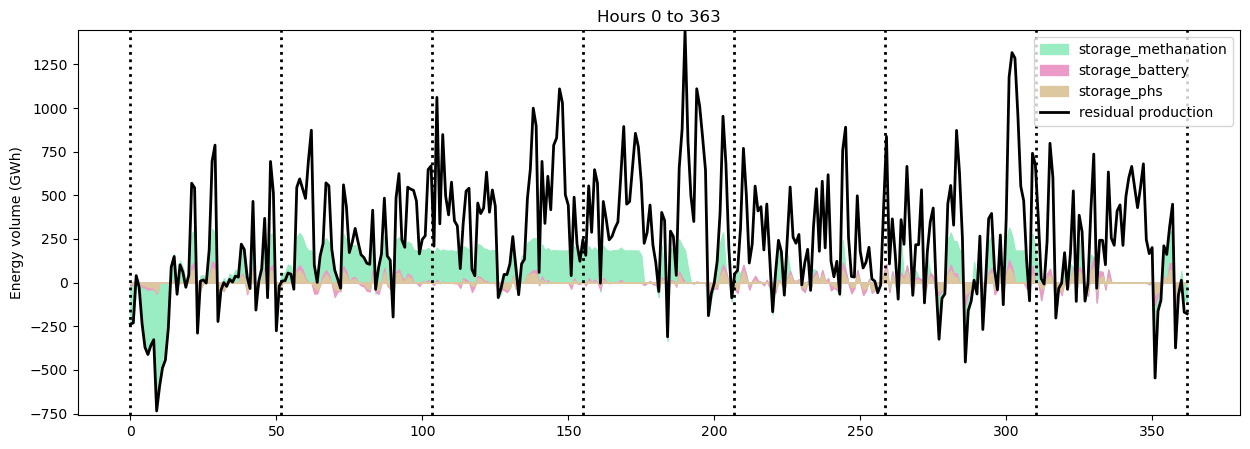

In [58]:
show_simu(0,363,df)

phs
battery
methanation


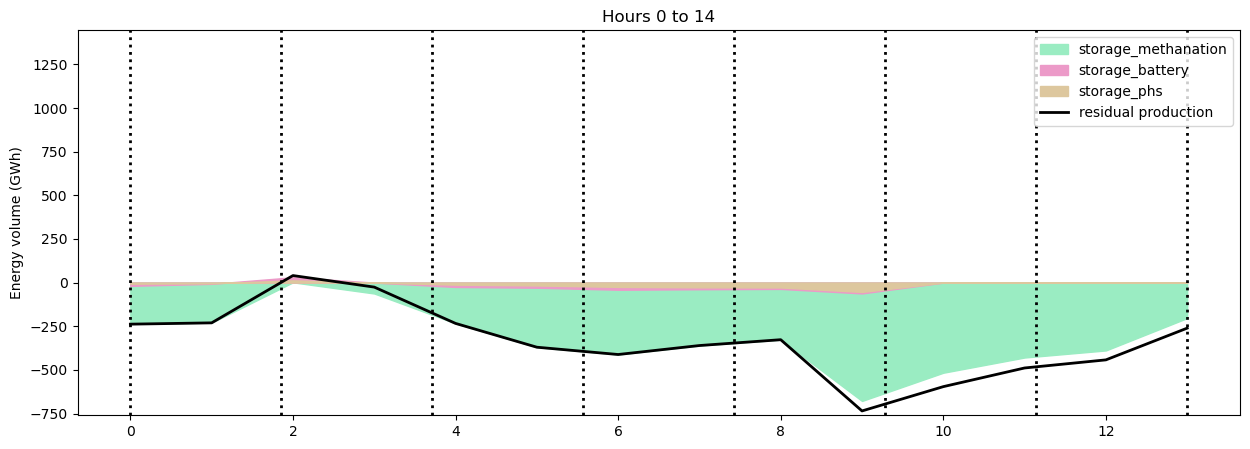

In [59]:
show_simu(0,14,df)

In [60]:
# df_simu = vrai simulation du modèle

df_simu = data.copy()
df_simu['storage_phs']=simu_phs
df_simu['storage_battery']=simu_bat
df_simu['storage_methanation']=simu_met

phs
battery
methanation


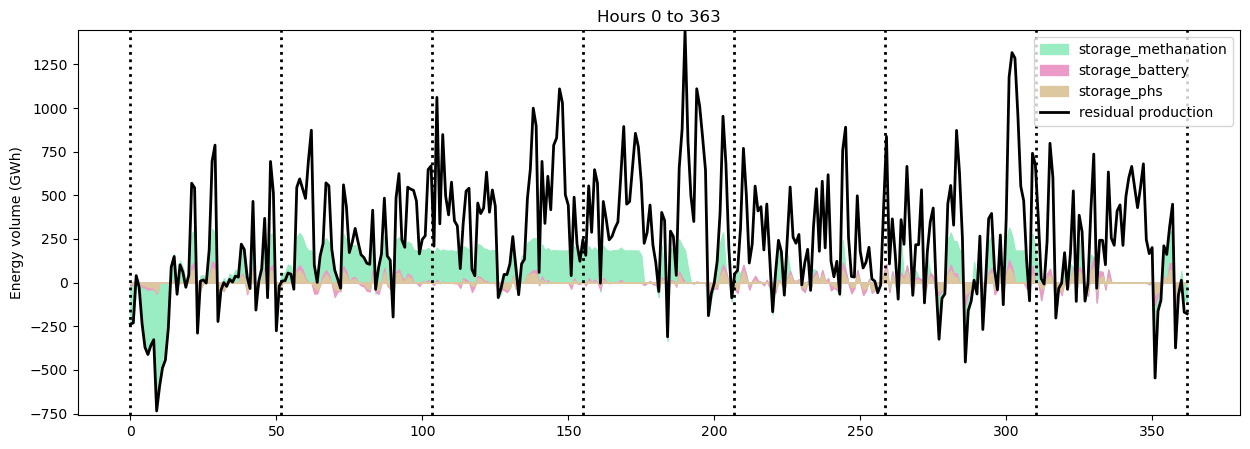

In [61]:
show_simu(0,363,df)

phs
battery
methanation


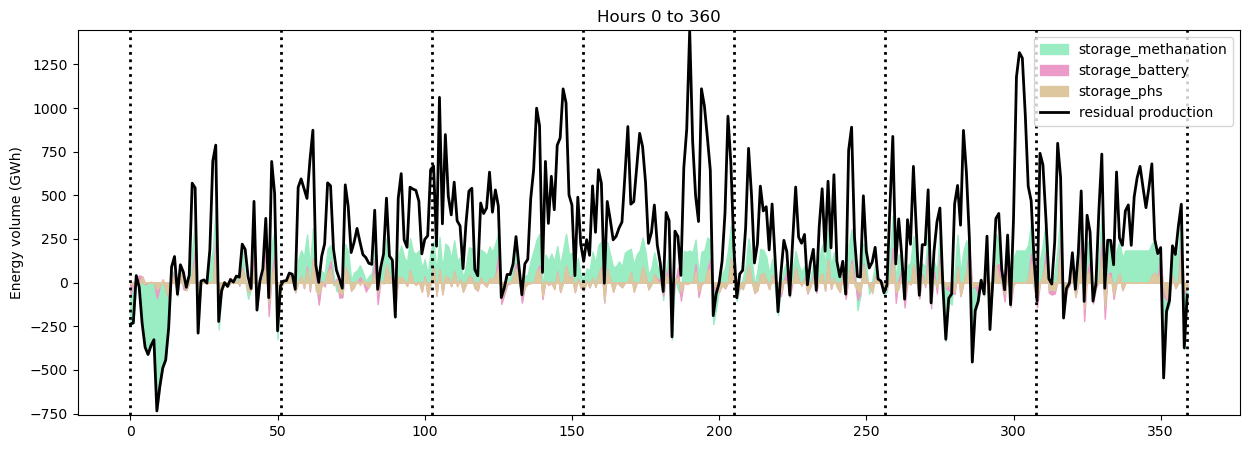

In [62]:
show_simu(0,360,df_simu)

phs
battery
methanation


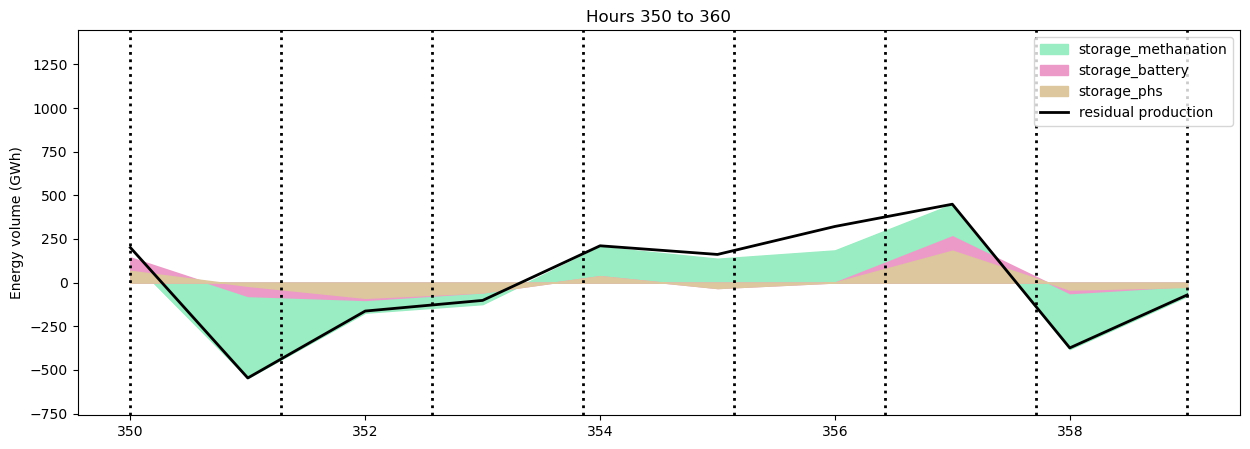

In [63]:
show_simu(350,360,df_simu)